# Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research here!). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [4]:
#data selection
ra = data[3].astype(float)
dec = data[4].astype(float) 
t_90 = data[6].astype(float)
t_90_err = data[7].astype(float)
t_100 = data[12].astype(float)
fluence = data[9].astype(float)
z = data[11].astype(float)
fluence_err = data[10].astype(float)

#checking that ra and dec are known for each sample
lenr = len(ra)
lend = len(dec)
ra = ra[ra!=-999]
dec = dec[dec!=-999]
lenr1 = len(ra)
lend1 = len(dec)
print('ra and dec defined for every object: ', lenr==lenr1, lend==lend1)
        
ind_z = []
for i in range(len(t_90)):
    if t_90[i] != -999 and fluence[i] != -999 and z[i] != -999 and fluence[i]!=0:
        ind_z.append(i)

#_sing values are the values for which the time and the error (present only on t90) are defined
t_90_sing= t_90[(t_90!=-999) & (t_90_err!=-999)]
t_90_err_sing = t_90_err[(t_90!=-999) & (t_90_err!=-999)]
t_100_sing= t_100[t_100!=-999]

#_ztrue values are the ones for which we have t_90, fluence and redshift
t_90_ztrue = t_90[ind_z]
fluence_ztrue = fluence[ind_z] 
t_100_ztrue = t_100[ind_z]
z_ztrue = z[ind_z]

#fluence per unit of time
fluence_per_time_ztrue = fluence_ztrue/t_100_ztrue

print(len(z_ztrue))
#print(len(t_90_true))
print(len(t_90_sing))

ra and dec defined for every object:  True True
544
5957


Let's begin with exploring the time data. Here I visualize T90 and T100 data.

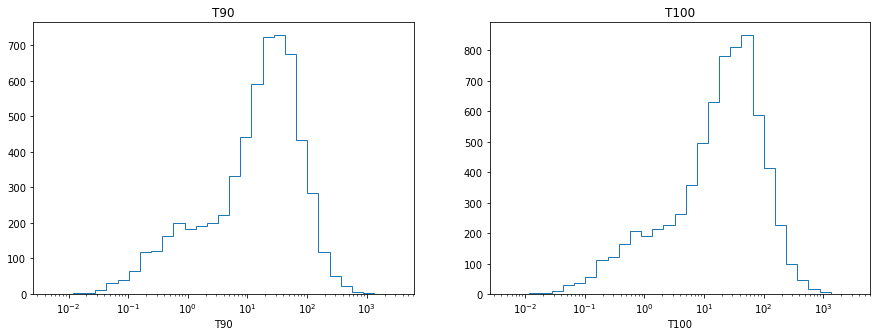

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

logbins = np.logspace(-2.3,3.5,32)
ax[0].hist(t_90_sing, bins=logbins, histtype='step')  #logarithmic bins!
ax[1].hist(t_100_sing, bins=logbins, histtype='step')

titles=['T90', 'T100']
for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(titles[i])

As we can clearly see the distribution of the time 'T90' over which 90% of the flux is emitted is has the same shape of the distribution of 'T100', the time over which the total flux is emitted, with the only difference that the values of 'T100' seem to be naturally shifted to slightly higher values. For this reason from now on I will consider the 'T90' distribution to analyse since uncertainties on 'T90' are given.

First of all let's look at the uncertainties: some of them seem to be quite high, therefore in the next cell I highlight the samples for which the uncertainty is bigger than 'T90' measured value. These points will not be used in the following analysis.

The data points to consider in the analysis represent the 0.95 of the total samples


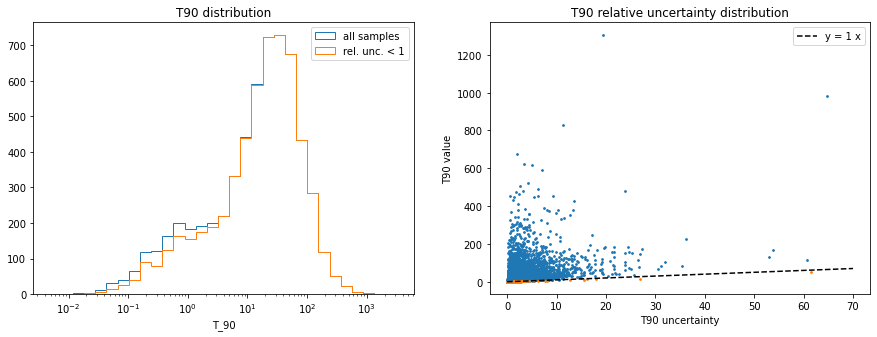

In [6]:
#Eliminating t90 points with high relative uncertainties
fig, ax = plt.subplots(1,2, figsize=(15,5))

n=1 # t_90/t_90_err limit

ax[0].hist(t_90_sing, bins=logbins, histtype='step', label='all samples')
ax[0].hist(t_90_sing[t_90_sing>n*t_90_err_sing], bins=logbins, histtype='step', label = 'rel. unc. < 1')
ax[0].set_xscale('log')
ax[0].set_xlabel('T_90')
ax[0].set_title('T90 distribution')
ax[0].legend()

ax[1].scatter(t_90_err_sing[t_90_sing>n*t_90_err_sing], t_90_sing[t_90_sing>n*t_90_err_sing], s=3)
ax[1].scatter(t_90_err_sing[t_90_sing<n*t_90_err_sing], t_90_sing[t_90_sing<n*t_90_err_sing], s=3)
ax[1].plot(np.linspace(0, 70, 100), np.linspace(0, 70, 100)*n, ls='--', c='black', label = 'y = %.0f x' %n)
ax[1].set_xlabel('T90 uncertainty')
ax[1].set_ylabel('T90 value')
ax[1].set_title ('T90 relative uncertainty distribution')
ax[1].legend()

#t_90_sing_1 are the t_90 with good relative uncertainties
t_90_sing_1 = t_90_sing[t_90_sing>n*t_90_err_sing]
t_90_err_sing_1 = t_90_err_sing[t_90_sing>n*t_90_err_sing]

print('The data points to consider in the analysis represent the %.2f of the total samples' %(len(t_90_sing_1)/len(t_90_sing)))

To help us visualize the distribution we could use a KDE algorithm, finding the optimal bandwidth with a cross-validation technique.

In [7]:
#finding the best bandwith with a K-fold process
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.logspace(-1.5,0, 30) 

print(bwrange)
K = 5 
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) 
grid.fit(np.log10(t_90_sing_1[:, None]))
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.03162278 0.03562248 0.04012807 0.04520354 0.05092096 0.05736153
 0.06461671 0.07278954 0.08199608 0.09236709 0.10404983 0.11721023
 0.13203518 0.14873521 0.16754749 0.18873918 0.21261123 0.23950266
 0.26979536 0.30391954 0.3423598  0.38566204 0.43444123 0.48939009
 0.55128898 0.62101694 0.69956422 0.78804628 0.88771971 1.        ]
0.11721022975334802


Text(0, 0.5, 'pdf(T90)')

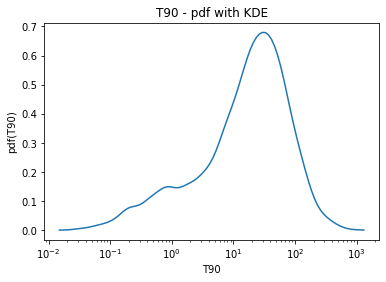

In [8]:
def kde_sklearn(data, bandwidth):
    kde_skl = KernelDensity(kernel='gaussian',bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) 
    return np.exp(log_pdf)

xgrid = np.linspace(np.log10(np.min(t_90_sing_1)), np.log10(np.max(t_90_sing_1)), 100)
pdf = kde_sklearn(np.log10(t_90_sing_1), bandwidth=h_opt) #using the optimal bandwidth found above
plt.plot(10**(xgrid),pdf)
plt.xscale('log')
plt.title('T90 - pdf with KDE')
plt.xlabel('T90')
plt.ylabel('pdf(T90)')

Since it is easy to recognize two gaussians in the histogram and the density function above I try to cluster data with the GaussianMixture algorithm.

### Gaussian Mixture

Text(0, 0.5, 'density')

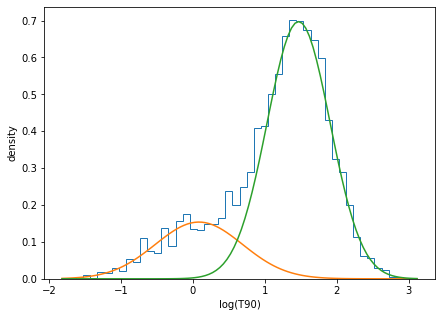

In [9]:
#Gaussian Mixture
fitfunc = GaussianMixture(n_components=2, n_init=100) #n_init is the number of initialization points from where the L is maximised
fit_g = fitfunc.fit(np.log10(t_90_sing_1[:,None]))

lnL = fit_g.score_samples((xgrid.reshape(-1,1)))
L = np.exp(lnL)
comp_prob = fit_g.predict_proba((xgrid.reshape(-1,1)))
ind_comp  = L[:,np.newaxis]*comp_prob
means = fit_g.means_

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(np.log10(t_90_sing_1), bins=50, density=True, histtype='step')
for i in range(2):
    plt.plot(xgrid, ind_comp[:,i])

#assign labels based on the most probable gaussian   
first_comp = np.argmin(means) #selecting the component with the lower mean to be the first one
if first_comp == 0: #this is the case in which they are already ordered
    first_lab = 0
    second_lab = 1
else:   #otherwise switch labels
    first_lab = 1
    second_lab=0
        
labels_gm = []
for i in range(len(t_90_sing_1)):
    #if the zeroth component is more probable append first label
    if fit_g.predict_proba(np.log10(t_90_sing_1[i].reshape(1,-1)))[0,0]>fit_g.predict_proba(np.log10(t_90_sing_1[i].reshape(1,-1)))[0,1]:
        labels_gm.append(first_lab)
    #otherwise append the second
    else:
        labels_gm.append(second_lab)
labels_gm = np.array(labels_gm)

ax.set_xlabel('log(T90)')
ax.set_ylabel('density')

Then let's try with KMeans clustering, imposing n_clusters = 2.

### KMeans

Text(0.5, 0, 'log(T90)')

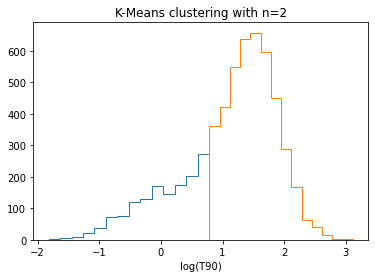

In [10]:
#KMeans clustering

X = np.log10(t_90_sing_1)
X = X[:, None]

clf = KMeans(n_clusters=2) 
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters centers
labels = clf.predict(X)        #labels for each of the points

#assigning ordered labels
if centers[0]>centers[1]:
    labels = np.where(labels==0, 1, 0)
    k = np.copy(centers[0])
    centers[0] = centers[1]
    centers[1] = k
    
# plot the data color-coded by cluster id
colors = ['tab:blue', 'tab:orange']

bins1 = np.linspace((np.min(X[labels==0])), (np.max(X[labels==0])), 15 )
bins2 = np.linspace((np.min(X[labels==1])), (np.max(X[labels==1])), 15 )

for ii in range(2):
    plt.hist(X[labels==ii], bins=bins1, edgecolor=colors[ii], histtype='step')
    plt.hist(X[labels==ii], bins=bins2, edgecolor=colors[ii], histtype='step') 
                
plt.title('K-Means clustering with n=2')
plt.xlabel('log(T90)')

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(labels_gm,labels)
print(cm)
print('\nThe two methods lead to the same results for: %.2f of the total samples' %accuracy_score(labels_gm, labels))

print('\nThe centroids from the Gaussian Mixture method are : ', means[0], means[1] )
print('\nThe centroids from the KMeans method are : ', centers[0], centers[1])

[[1191    0]
 [ 245 4248]]

The two methods lead to the same results for: 0.96 of the total samples

The centroids from the Gaussian Mixture method are :  [0.08169403] [1.46845416]

The centroids from the KMeans method are :  [0.06667675] [1.50779897]


Some of the samples are classified as part of the high-mean cluster with the Gaussian Mixture method and in low-mean cluster with the KMeans method. This is due to the fact that the KMeans limit between the classes is higher than the Gaussian Mixture limit that I have assumed to be in the point where the probability of the two Gaussians is the same.

Let's also try with MeanShift method, here we don't need to specify the number of clusters, but we need to choose a bandwidth for the KDE. 

### MeanShift

In [12]:
#MeanShift
clms = MeanShift(bandwidth=0.3, cluster_all=True)
clms.fit(X)
centers_ms = clms.cluster_centers_
labels_ms = clms.predict(X)         #labels for each of the points
n_clusters_ms = len(centers_ms)
print('The number of clusters found in the data is: ', n_clusters_ms)

The number of clusters found in the data is:  2


With the MeanShift method I have chosen a bandwidth of about 0.3 because with this value the clusters produced are 2, it's like I have used some prior knowledge from the analysis above ;)
Infact with the optimal value found for the KDE bandwidth above, the resulting clusters would be about 18! This of course could be a sign of the fact that these two clusters can be splitted into subclusters.

Text(0.5, 1.0, 'MeanShift clustering')

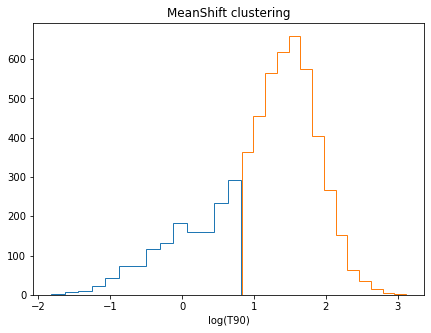

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

#assigning ordered labels
if centers_ms[0]>centers_ms[1]:
    labels_ms = np.where(labels_ms==0, 1, 0)
    k = centers_ms[0]
    centers_ms[0] = centers_ms[1]
    centers_ms[1] = k
 
bins=[]
for i in range(n_clusters_ms):
    bins = np.linspace((np.min(X[labels_ms==i])), (np.max(X[labels_ms==i])), 15)
    ax.hist(X[labels_ms==i], bins=bins, histtype='step')

ax.set_xlabel('log(T90)')
ax.set_title('MeanShift clustering')

In [14]:
cm = confusion_matrix(labels_gm,labels_ms)
print(cm)
print('\nThe two methods (GM - MS) lead to the same results for: %.2f of the total samples' %accuracy_score(labels_gm, labels_ms))

cm = confusion_matrix(labels,labels_ms)
print('\n', cm)
print('\nThe two methods (KM - MS) lead to the same results for: %.2f of the total samples' %accuracy_score(labels, labels_ms))


[[1191    0]
 [ 314 4179]]

The two methods (GM - MS) lead to the same results for: 0.94 of the total samples

 [[1436    0]
 [  69 4179]]

The two methods (KM - MS) lead to the same results for: 0.99 of the total samples


Results obtained with MeanShift are very similar to the ones found with KMeans, with only a small number of differently classified samples on a total of >5000 items! However previous knowledge was necessary for tuning the bandwidth of the MeanShift estimator, so maybe it's not the most reliable algorithm to use in this case.

### Exploring

"Is there any relation between the time and the emitted flux?" this is the question that came to my mind while lookng at the dataset, here I try to dig deeper into it.

In [15]:
#taking the points for which necessary info (fluence, fluence_err, T100) is provided

ind = []
for i in range(len(t_90)):
    if t_90[i] != -999 and fluence[i] != -999 and fluence_err[i] != -999 and t_100[i]!=-999 and fluence[i]!=0:
        ind.append(i)

fluence_true = fluence[ind] 
t_100_true = t_100[ind]
fluence_per_time = fluence_true/t_100_true
fluence_err_true = fluence_err[ind]
fluence_per_time_err = fluence_err_true/t_100_true


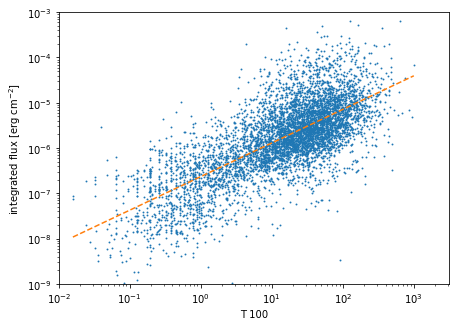

In [16]:
#fluence-vs-time
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.scatter(t_100_true, fluence_true, s =0.8)
ax.set_ylim(10**(-9), 10**(-3))
ax.set_xlim(10**(-2), 10**3.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('T 100')
ax.set_ylabel('integrated flux [erg cm$^{-2}$]')

#quick linear fit
def linear(x,m,q):
    return m*x + q

from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear, np.log10(t_100_true), np.log10(fluence_true), p0 = [1, -7])
x_grid = np.logspace(-1.8,3, 100)
ax.plot(x_grid, x_grid**popt[0]*10**popt[1], ls='--', color='tab:orange' )

It's easy to see how it seems to be a linear relation between the two variables, such that the longer is the time during which the signal is emitted the longer should be the integrated flux in time. To discern whether this is a natural effect or not we can have a look at the fluence per time, to see if depending on the time of emission we could see any changes in the flux emitted per unit time.

Text(0, 0.5, 'fluence/T100 [erg cm$^{-2}$ s$^{-1}$]')

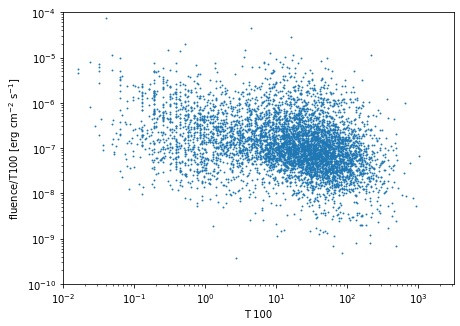

In [17]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
chosen_2000 = np.random.randint(0, len(t_100_true), 2000)
ax.scatter(t_100_true, fluence_per_time, s =0.8)
ax.set_ylim(10**(-10), 10**(-4))
ax.set_xlim(10**(-2), 10**3.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('T 100')
ax.set_ylabel('fluence/T100 [erg cm$^{-2}$ s$^{-1}$]')

From this last plot we can see two blobs, on the right there are the long lasting GRBs that have a smaller fluence per time, while on the left the short GRBs that seem to have a slightly bigger fluence per time. Moreover it seems that in each cluster the longer the time is the lower fluence per time we observe, with mean fluence per time being higher in short GRBs. We can therefore try to apply KMeans custering in these two dimensions.

Text(0, 0.5, 'log(fluence per time)')

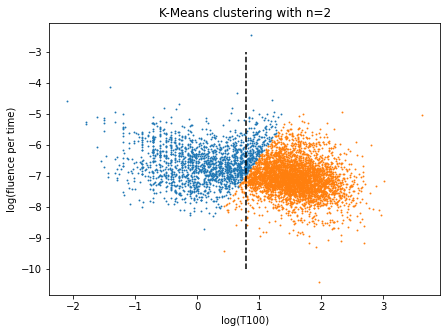

In [21]:
#KMeans in 2d
XX = np.array([np.log10(t_100_true), np.log10(fluence_per_time)])
XX = XX.T

#clf = MeanShift(bandwidth=0.38, bin_seeding=True, cluster_all=True) 
clf = KMeans(n_clusters=2, n_init=500)
clf.fit(XX)
centers_2d = clf.cluster_centers_ #location of the clusters centers
labels_2d = clf.predict(XX)        #labels for each of the points

if centers_2d[0,0]>centers_2d[1,0]:
    labels_2d = np.where(labels_2d==0, 1, 0)
    k = centers_2d[0,:]
    centers_2d[0,:] = centers_2d[1,:]
    centers_2d[1,:] = k
    
# plot the data color-coded by cluster id
colors = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.scatter(XX[:,0][labels_2d==0], XX[:,1][labels_2d==0], s=0.8) 
ax.scatter(XX[:,0][labels_2d==1], XX[:,1][labels_2d==1], s=0.8)

ax.vlines(np.max(X[labels==0]), -10, -3, color='black', ls='--')


ax.set_title('K-Means clustering with n=2')
ax.set_xlabel('log(T100)')
ax.set_ylabel('log(fluence per time)')



In black I've marked the limit between clusters that we found with the KMeans estimator applied only in 1 dimension (actually this is just a "proxy" since we clustered samples based on their T90 values, while here we have T100, but at the very beginning we saw how these two distributions were very similar). Some points that were previously classified as long GRBs are now in the short GRB cluster since their fluence per time is pretty high.

What about redshift?? In the plot below I show the redshift distribution, and as we saw in the case of quasars this is not exactly what we would expect if GRBs were uniformly distributed in space. This effect, however, could be due to flux-limited instruments that are not receiving enough signal from distant GRBs to detect them.

Text(0.5, 1.0, 'Redshift distribution')

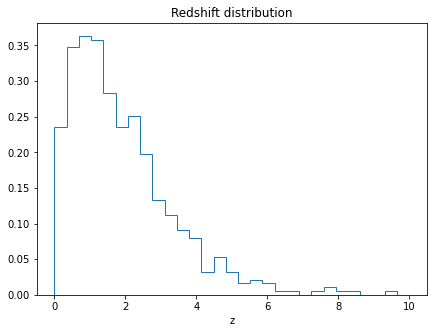

In [19]:
#redshift distribution
fig, ax = plt.subplots(1,1, figsize=(7,5))

linbins = np.linspace(0.005, 10, 30)
ax.hist(z_ztrue, bins=linbins, density=True, histtype='step')
ax.set_xlabel('z')
ax.set_title('Redshift distribution')

Text(0, 0.5, 'log(T90)')

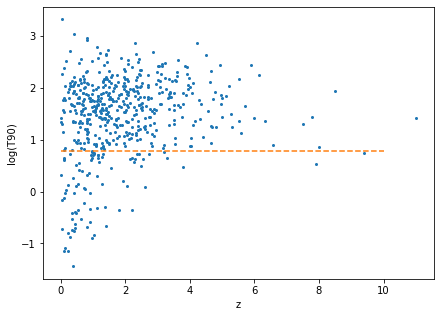

In [20]:
#redshift and time
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.scatter(z_ztrue, np.log10(t_90_ztrue), s=4)
ax.plot(np.linspace(0,10,100), np.linspace(0,10,100)*0+np.max(X[labels==0]), color='tab:orange', ls='--')

ax.set_xlabel('z')
ax.set_ylabel('log(T90)')

At high redshift (z>3) we can see mainly long GRBs, as this plot seems to suggest. The orange dashed line is the limit we found with KMeans estimator on the variable T90.